# Exercise 4: Interventions

Here we will practice altering the starting conditions and structure of our SIR model in order to represent what will happen when we add interventions. Each version of our model represents a different modeling scenario. By comparing different scenarios, we can imagine different ways that the outbreak will occur under different conditions.

In [1]:
# Load libraries
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

# Use scipy.optimize.minimize to mnimizes sum of squared errors function
from scipy.optimize import minimize

In [2]:
# Load plague Data
plague_dat = pd.read_csv('plague_data.csv')
plague_dat['time'] = plague_dat.index.values

plague_dat.head()

,Week_of_year,Deaths,time
0,39,31,0
1,40,18,1
2,41,12,2
3,42,9,3
4,43,13,4


In [3]:
# Define a function for numerically integrating the SIR model
def sir_model(state, time, parameters):
    # Unpack Parameters
    S, I, R = state
    beta, gamma = parameters
    
    # Calculate total population size
    N = S + I + R
    
    # Calculate force of infection
    lambd = beta * I / N
    
    # Calculate derivatives
    dS = -lambd * S
    dI = lambd * S - gamma * I
    dR = gamma * I
    
    # Return derivative
    return [dS, dI, dR]

In [4]:
# Using the fit values from before, generate a "baseline solution" to the model

# Using the optimized parameter values from before
parameters = {'beta': 2.67546942, 'gamma': 2.20012301}

# Define times - start at week 10
times = np.arange(10, 76, 1)


# Initial state values
initial_state_values = [55000 - 1, 1, 0]

sir_fit = odeint(sir_model, initial_state_values, times, args=(list(parameters.values()),))
sir_fit = pd.DataFrame(sir_fit, columns=['S', 'I', 'R'])
sir_fit['time'] = times


# Part 1: Vaccination with a perfect vaccine
Suppose we are able to vaccinate a certain fraction of susceptibles in the population before the outbreak starts, such that they never become infected.

We represent this by removing a fraction of the susceptible population at the start, and see whether the outbreak takes off. Let p_vaccinated = fraction of susceptibles who are vaccinated.

Start by letting p_vaccinated = .1:

In [5]:
# Using the optimized parameter values from before
parameters = {'beta': 2.67546942, 'gamma': 2.20012301}

# Define times - start at week 10
times = np.arange(10, 76, 1)

# Adjust vaccinated proportion p.vaccinated here:
p_vaccinated = 0.1

# Initial state values
initial_state_values = [55000 * (1 - p_vaccinated) - 1, 1, 55000 * p_vaccinated]

# Solve the vaccinated model
sir_vaccinated = odeint(sir_model, initial_state_values, times, args=(list(parameters.values()),))
sir_vaccinated = pd.DataFrame(sir_vaccinated, columns=['S', 'I', 'R'])
sir_vaccinated['time'] = times

sir_vaccinated = pd.DataFrame(sir_vaccinated)

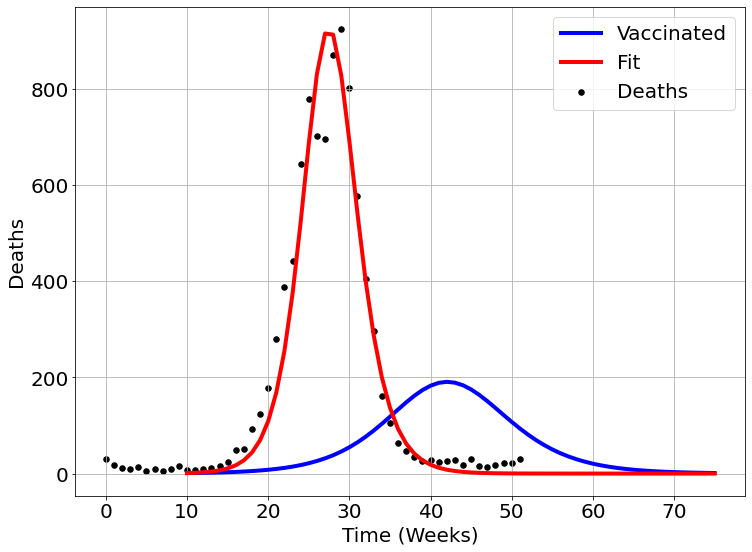

In [6]:
# Create a plot
plt.figure(figsize = (12,9))
plt.plot(sir_vaccinated['time'], sir_vaccinated['I'], color='blue', linewidth=4, label='Vaccinated')
plt.plot(sir_fit['time'], sir_fit['I'], color='red', linewidth=4, label='Fit')
plt.scatter(plague_dat['time'], plague_dat['Deaths'], color='black', s=30, label='Deaths')
plt.xlabel("Time (Weeks)",fontsize = 20)
plt.ylabel("Deaths",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

## Question: Cases averted through vaccination
How many people became infected overall?




In [7]:
sir_vaccinated["R"].values[-1]

13786.865637202445

How does that compare to the number of people who became infected before?

In [8]:
sir_fit["R"].values[-1]

18314.822700050227

# Part 2: Treatment of infected individuals
Suppose that treatment decreases the amount of infectious time by 25%. 
The way we represent this is by dividing the "Infected" compartment into two, where one receives the treatment and the other does not. In the treated compartment, gamma -> gamma/(.75) (recovery rate increases by 1/.75).

How many cases need to be treated in order to prevent an outbreak?

Start by defining a new model with the treated compartment. This time there are four state variables, where we've added I_t to represent the number of infected people on treatment:

In [9]:
def sir_model_treatment(state, time, parameters):
    S, I, I_t, R = state
    beta, gamma, p_treatment = parameters

    N = S + I_t + I + R

    lambd = beta * (I + I_t) / N

    dS = -lambd * S
    dI_t = lambd * S * p_treatment - gamma / 0.75 * I_t
    dI = lambd * S * (1 - p_treatment) - gamma * I
    dR = gamma * I + 2 * gamma * I_t

    return [dS, dI, dI_t, dR]

p_treated is the probability that an individual receives treatment. Start by setting that equal to 0.25:

In [10]:
parameters = [2.559449, 2.109450, 0.25]

times = np.arange(10, 76, 1)

initial_state_values = [54999, 1, 0, 0]

sir_treated = odeint(sir_model_treatment, initial_state_values, times, args=(parameters,))
sir_treated = pd.DataFrame(sir_treated, columns=['S', 'I', 'I_t', 'R'])
sir_treated['time'] = times

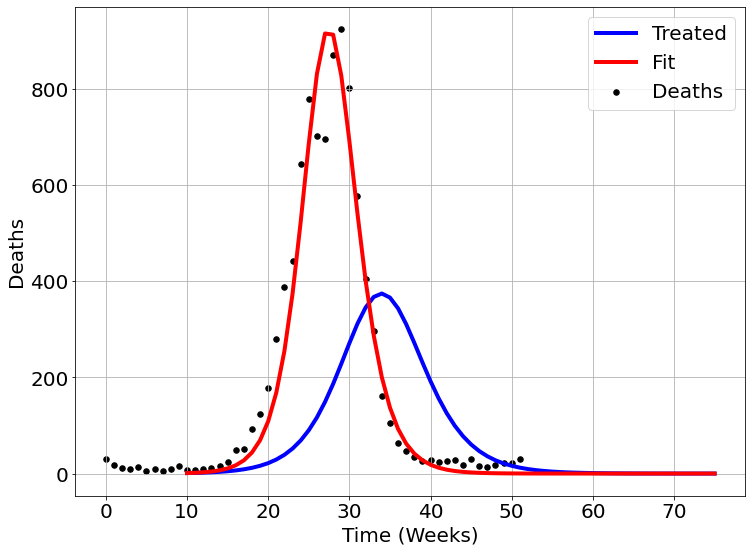

In [11]:
# Create a plot
plt.figure(figsize = (12,9))
plt.plot(sir_treated['time'], sir_treated['I'] + sir_treated['I_t'], color='blue', linewidth=4, label='Treated')
plt.plot(sir_fit['time'], sir_fit['I'], color='red', linewidth=4, label='Fit')
plt.scatter(plague_dat['time'], plague_dat['Deaths'], color='black', s=30, label='Deaths')
plt.xlabel("Time (Weeks)",fontsize = 20)
plt.ylabel("Deaths",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()


In [12]:
## Question: Cases averted through treatment
How many people became infected overall when we add treatment?

Object `treatment` not found.


In [13]:
sir_treated["R"].values[-1]

13017.640176705885

How does that compare to the number of people who became infected in the original scenario?

In [14]:
sir_fit["R"].values[-1]

18314.822700050227

# Optional Exercise 1: stopping an outbreak with vaccinations
Try adjusting p.vaccinated: how large does it need to be in order to stop an outbreak from occurring?


## Optional exercise

In this new vaccination scenario, we have altered the structure of our model.

Find an expression for R_0 as a function of beta, gamma, and p.vaccinated. Solve for p.vaccinated such that R_0 = 1. Compare the value of p.vaccinated to the value that you found which was high enough to stop an outbreak from occurring.



## Optional exercise

Suppose instead of providing perfect protection against plague, the vaccine only protected 50% of people who received it. What structural changes would we need to make to our model in order to represent this? How do your answers to each of the above questions change in this alternate scenario?

# Optional Exercise 2: stopping an outbreak with treatment
Try adjusting the parameters in the treatment scenario - what coverage is needed to stop an epidemic altogether?


## Optional exercise

In this new treatment scenario, we have altered the structure of our model.

Find an expression for R_0 as a function of beta, gamma, p_treatment, and the factor which changes the rate at which infected people recover with treatment. Solve for p.treatment such that R_0 = 1. Compare the value of p.treatment to the value that you found which was high enough to stop an outbreak from occurring.



## Optional exercise

Suppose that treatment does not shorten the duration of the infectious period, and instead it reduces the per-contact rate of transmission (beta) by 50%. What structural changes would we need to make to our model in order to represent this? How do your answers to each of the above questions change in this alternate scenario?
